I have used the following methods.

* I used a pretrained <b>ViT</b> architecture for the feature extraction stage [1],
* <b>gelu</b> activation function during the classification stage,
* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,

<br>

## My Other Projects

* [Smoking Detection w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/smoking-detection-w-online-learning-river)
* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice : 0.91, Jaccard : 0.82)](https://github.com/john-fante/my-deep-learning-projects/tree/main/segmentation-projects/eye-conjunctiva-segmentation-main)
* [Retina Vessel Segmentation w/TPU (Test Dice: 0.75)](https://www.kaggle.com/code/banddaniel/retina-vessel-segmentation-w-tpu-test-dice-0-75)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output
!pip install vit_keras
clear_output()

In [103]:
# Importing dependencies

import warnings
import logging
import os 
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from vit_keras import vit


IMG_SIZE = 224, 224
BATCH_SIZE = 128
SEED = 4
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [4]:
# Connecting TPU and creating strategy and the model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [42]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    full_path_links = sorted(os.listdir(full_path))
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    
    for i in range(len(full_path_links)):
        x = create_images_list(os.path.join(full_path, full_path_links[i]))
        img_rows.extend(x)
        label_rows.extend([i]*len(x))
    
    data['img'] = img_rows
    data['label'] = label_rows
    
    return data



# look-up table
classes = {0: 'advertisement', 1: 'budget', 2: 'email', 3: 'file folder', 4: 'form', 5: 'handwritten', 6: 'invoice', 7: 'letter', 8: 'memo', 9: 'news article', 10: 'presentation', 11: 'questionnaire', 12: 'resume', 13: 'scientific publication', 14: 'scientific report', 15: 'specification'}



full_data = create_full_img_class_df('/kaggle/input/financial-document-classification/Financial_Data/Financial Data')
test_data = create_full_img_class_df('/kaggle/input/financial-document-classification/Financial_data_test/Financial_data_test')

X_train,X_val, y_train, y_val = train_test_split(full_data['img'], full_data['label'], test_size = 0.2, stratify = full_data['label'])

print("train images: ", X_train.shape[0])
print("val images: ", X_val.shape[0])
print("test images: ", test_data.shape[0])

train images:  38396
val images:  9600
test images:  39996


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [50]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label
    
    
# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_brightness(image, 0.2, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_flip_left_right(img, seed = SEED)

    return img, label

In [105]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


val_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (val_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Pre-trained ViT </span> Model

In [106]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 16)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(128, activation = 'gelu')(X)
    X = Dense(64, activation = 'gelu')(X)
    out = Dense(16, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.0001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_acc")] )

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_15 (Flatten)        (None, 768)               0         
                                                                 
 dense_90 (Dense)            (None, 128)               98432     
                                                                 
 dense_91 (Dense)            (None, 64)                8256      
                                                                 
 dense_92 (Dense)            (None, 16)                1040      
                                                                 
Total params: 85906384 (327.71 MB)
Trainable params: 85906

In [107]:
# Training model

hist = model.fit(train_dataset, epochs = 8, batch_size = BATCH_SIZE, validation_data = val_dataset)

Epoch 1/8


2023-12-18 16:15:30.075021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.


300/300 [==============================] - ETA: 0s - loss: 1.2994 - acc: 0.6046 - top_5_acc: 0.8798

2023-12-18 16:17:21.435302: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 158s 242ms/step - loss: 1.2994 - acc: 0.6046 - top_5_acc: 0.8798 - val_loss: 0.9755 - val_acc: 0.6980 - val_top_5_acc: 0.9421
Epoch 2/8
300/300 [==============================] - 61s 204ms/step - loss: 0.7955 - acc: 0.7580 - top_5_acc: 0.9560 - val_loss: 0.7880 - val_acc: 0.7567 - val_top_5_acc: 0.9565
Epoch 3/8
300/300 [==============================] - 60s 200ms/step - loss: 0.5847 - acc: 0.8208 - top_5_acc: 0.9741 - val_loss: 0.7880 - val_acc: 0.7627 - val_top_5_acc: 0.9556
Epoch 4/8
300/300 [==============================] - 60s 200ms/step - loss: 0.4496 - acc: 0.8615 - top_5_acc: 0.9837 - val_loss: 0.7725 - val_acc: 0.7746 - val_top_5_acc: 0.9588
Epoch 5/8
300/300 [==============================] - 60s 201ms/step - loss: 0.3520 - acc: 0.8913 - top_5_acc: 0.9899 - val_loss: 0.7287 - val_acc: 0.7959 - val_top_5_acc: 0.9591
Epoch 6/8
300/300 [==============================] - 60s 200ms/step - loss: 0.2546 - acc: 0.9217 - top_5_acc: 0.9940 - 

# <span style="color:#e74c3c;"> Training</span> Results

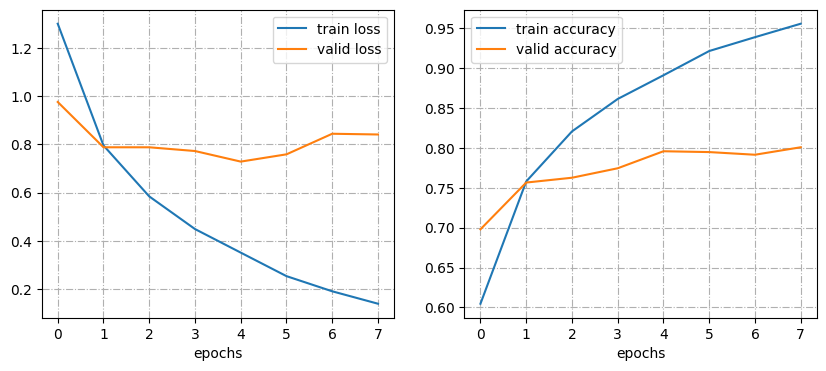

In [108]:
fig, axs = plt.subplots(1,2, figsize = (10, 4), dpi = 100)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].legend(['train loss', 'valid loss'], fontsize = 10)


axs[1].grid(linestyle = 'dashdot')
axs[1].plot(hist.history['acc'])
axs[1].plot(hist.history['val_acc'])

axs[1].set_xlabel('epochs', fontsize = 10)
axs[1].legend(['train accuracy', 'valid accuracy'], fontsize = 10)

# <span style="color:#e74c3c;"> Test </span> Evaluations

In [109]:
# Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
313/313 [==============================] - 30s 94ms/step - loss: 0.8908 - acc: 0.7891 - top_5_acc: 0.9558
Test Loss: 0.891
Test Accuracy: 78.905 %


# <span style="color:#e74c3c;"> Test </span> Prediction

In [110]:
# predictions

with stg.scope():
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    pred = np.argmax(pred, axis = 1)
    
    
# Predictions and scores

mse = mean_squared_error(test_data['label'], pred)
f1 = f1_score(test_data['label'], pred, average = 'weighted')
acc = accuracy_score(test_data['label'], pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

2023-12-18 16:25:40.516767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


313/313 [==============================] - 42s 98ms/step
Mean Squared Error : 9.43457
Weighted F1 Score : 0.791
Accuracy Score : 78.905 %


# <span style="color:#e74c3c;"> Classification </span> Report

In [111]:
clf = classification_report(test_data['label'], pred, target_names = list(classes.values()))
print(clf)

                        precision    recall  f1-score   support

         advertisement       0.82      0.88      0.85      2515
                budget       0.80      0.69      0.74      2505
                 email       0.93      0.96      0.94      2516
           file folder       0.89      0.91      0.90      2527
                  form       0.59      0.65      0.62      2506
           handwritten       0.95      0.84      0.89      2532
               invoice       0.80      0.74      0.77      2477
                letter       0.70      0.84      0.76      2464
                  memo       0.87      0.78      0.82      2492
          news article       0.89      0.78      0.83      2463
          presentation       0.64      0.75      0.69      2489
         questionnaire       0.73      0.65      0.69      2435
                resume       0.92      0.85      0.89      2536
scientific publication       0.91      0.82      0.87      2569
     scientific report       0.58      

# <span style="color:#e74c3c;"> Confusion </span> Matrix

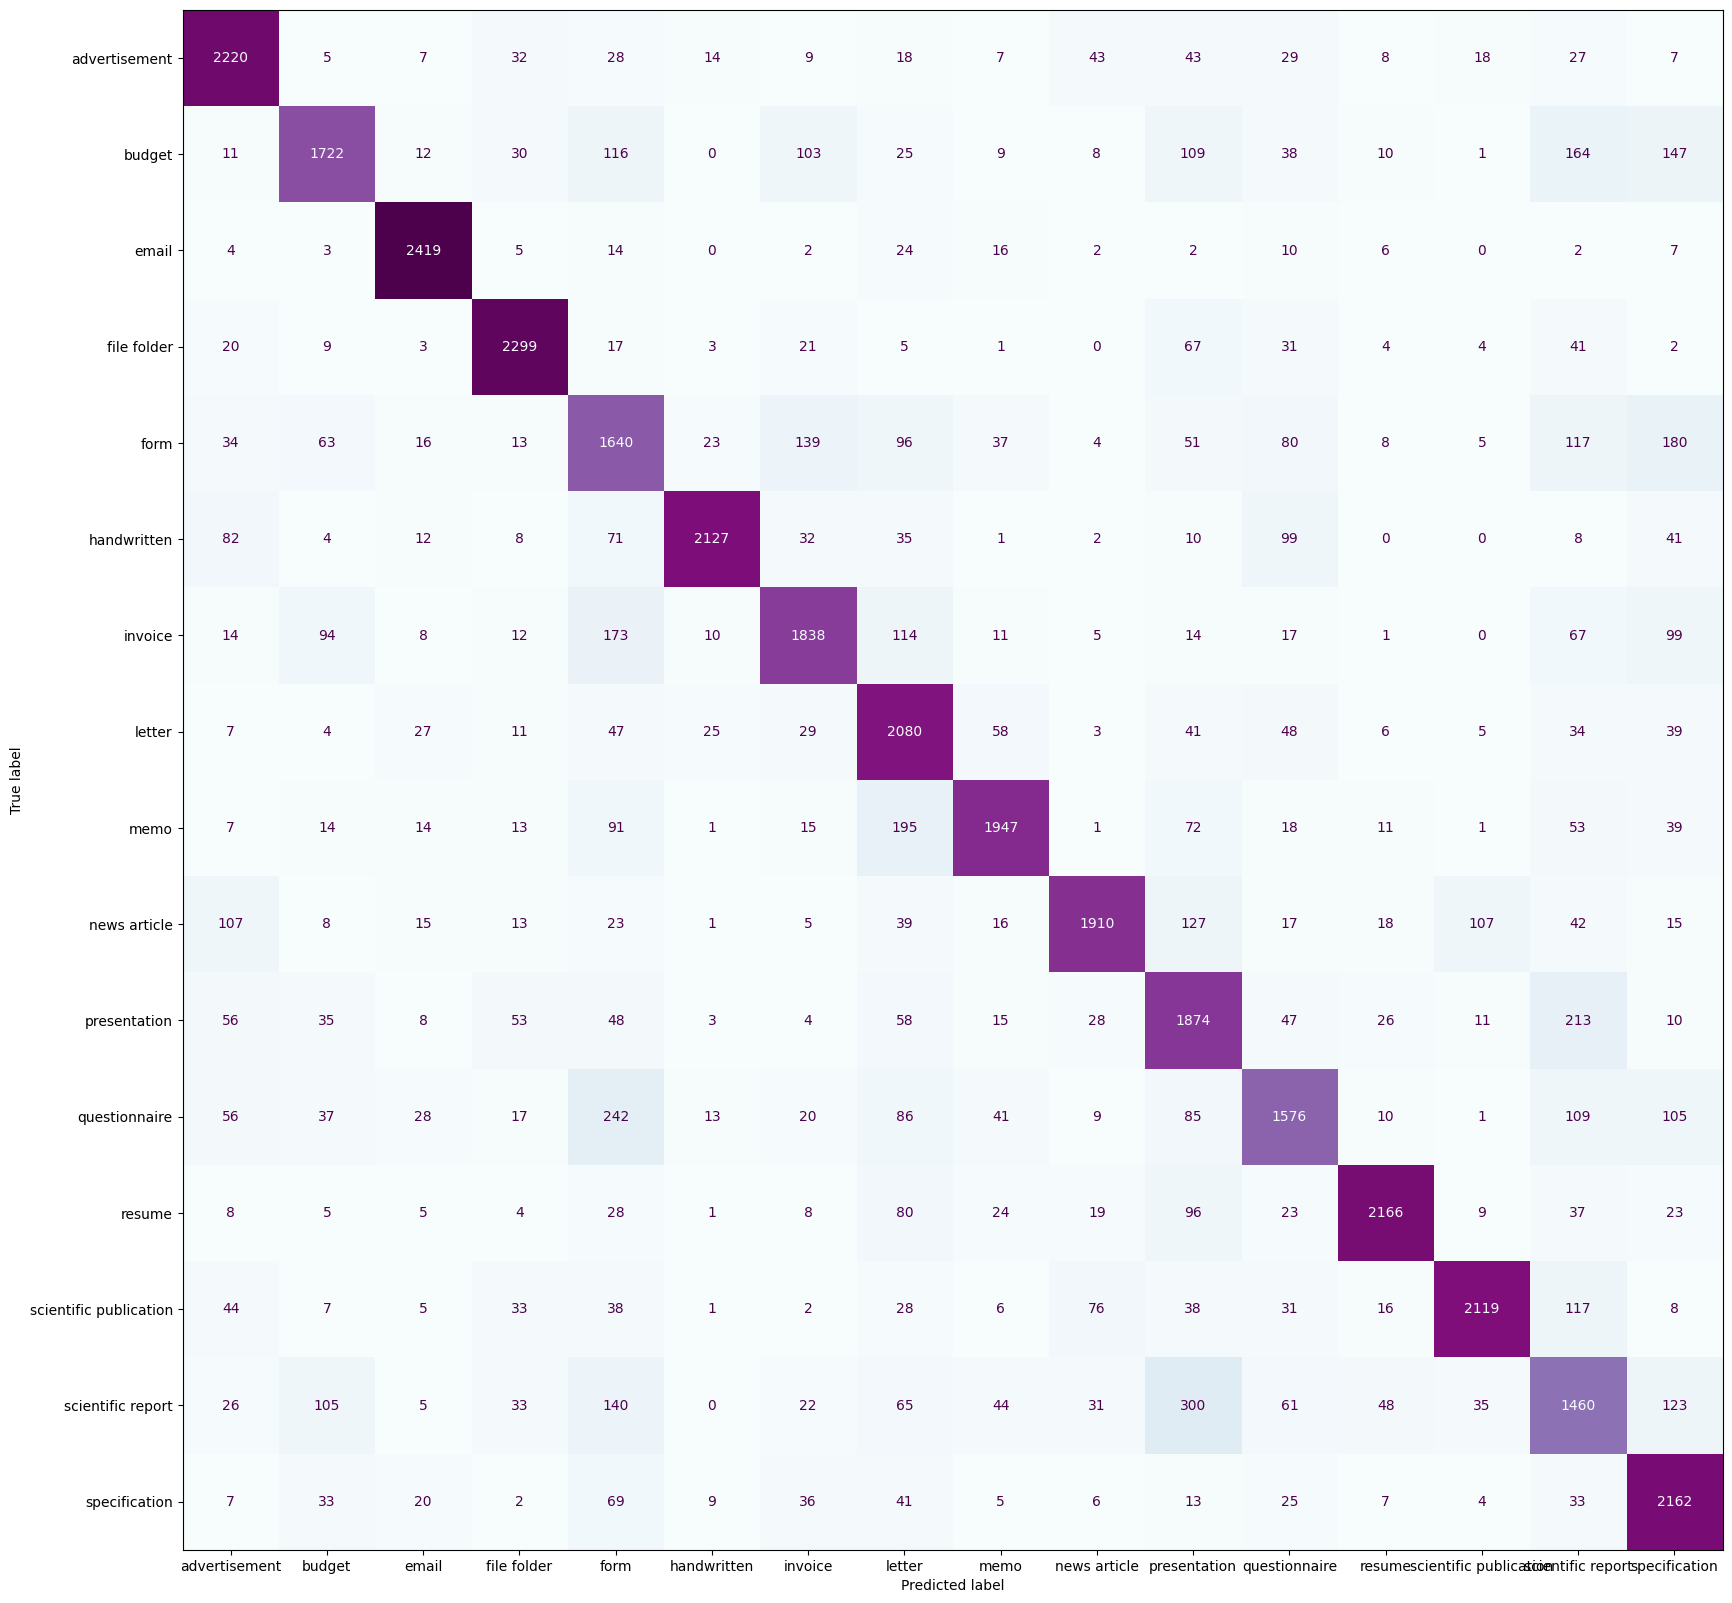

In [112]:
cm = confusion_matrix(test_data['label'], pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(20,20))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [113]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

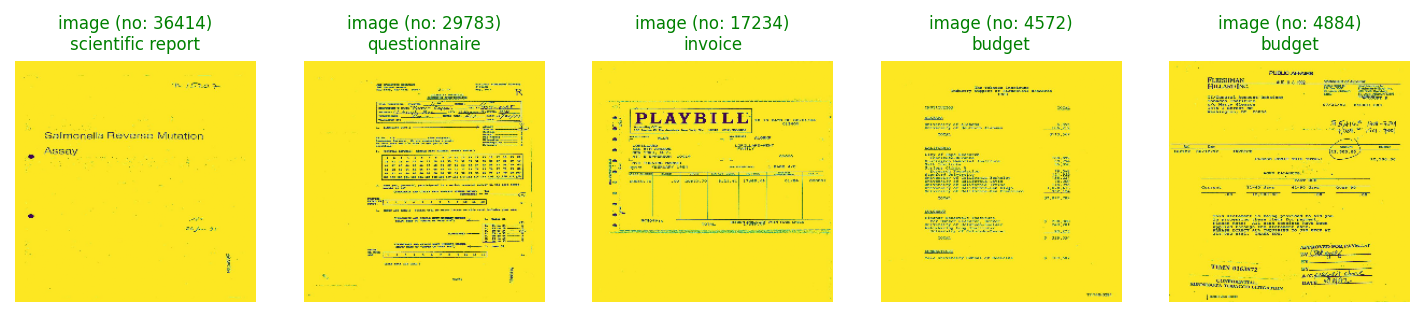

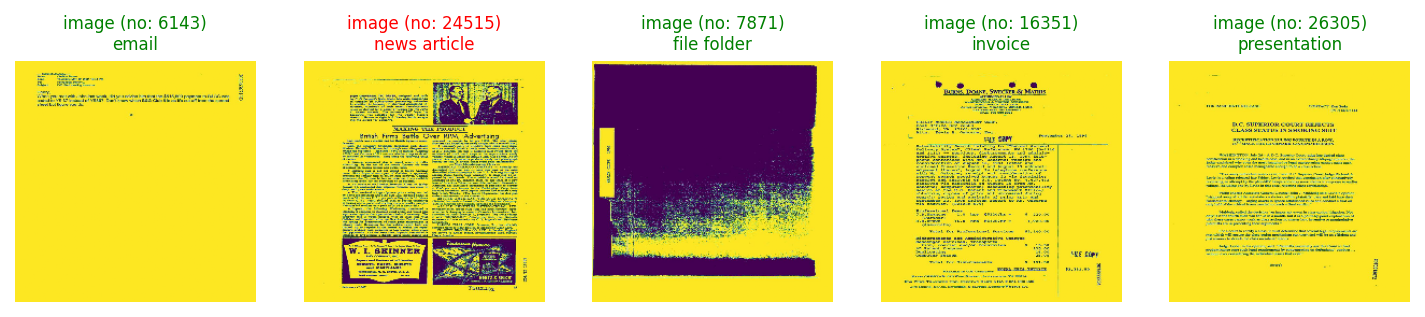

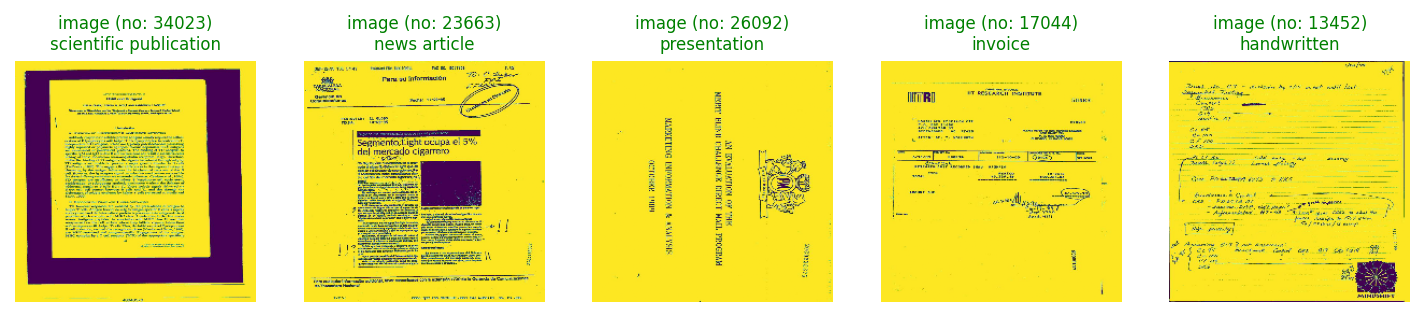

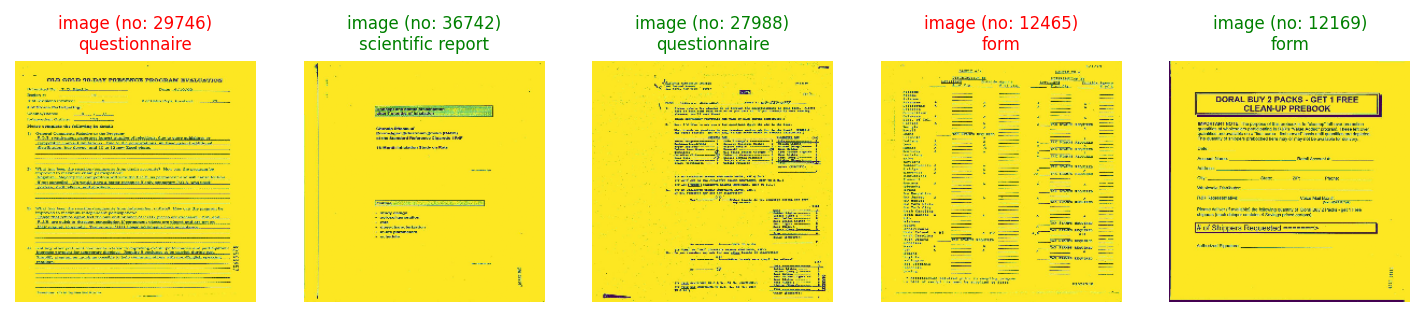

In [114]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 55)
random_test_sample_with_prediction(SEED = 9)
random_test_sample_with_prediction(SEED = 62)
random_test_sample_with_prediction(SEED = 4)